In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import scipy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
plt.style.use('seaborn')


from model_classifier.classifier import MinstC, Classifier
from model_classifier.config import mConfig1
from supriseAdequacy.calc import activations, calc_lsa, calc_img_lsa, calculate_dsa, calc_img_lsa2
from supriseAdequacy.optimazation import hill_climbing, simulated_annealing
from models.vae import ConvVAE, DCVAE
from models.dcgan import Discriminator, Generator
from models.configurations import d_config, g_config

In [2]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# config

# MinstClassifier
minstC = MinstC(mConfig1)
minstC_weight = 'training_weights/classifier_minst4.pth'
minstC.load_state_dict(torch.load(minstC_weight, map_location= device))
minstC.eval()

# ConvVae didn't took dynamic one would need to do the config for it first
encoded_space_dim = 4
fc2_input_dim = 128
convae = ConvVAE(encoded_space_dim= encoded_space_dim , fc2_input_dim= fc2_input_dim)
Cvae_weight = 'training_weights/vae_model.pth'
convae.load_state_dict(torch.load(Cvae_weight, map_location= device))
convae.eval()


generator = Generator(g_config)
gen_weight = 'training_weights/generator.pth'
generator.load_state_dict(torch.load(gen_weight, map_location= device))
generator.eval()
#discriminator = Discriminator(d_config)
#dis_weight = 'training_weights/discriminator.pth'
#discriminator.load_state_dict(torch.load(dis_weight, map_location= device))
#discriminator.eval()



Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [4]:
# chose activation layer (two methods used mine), calculate the activations (pretty much as in sinvad with minor differences)
act_layer = minstC.at_by_layer2
act = activations(train_data_loader, act_layer, 512, 11, 0.6, 100, device)
kde, result = act

In [5]:
lsas = []
for i, (x, x_class) in enumerate(test_data_loader):
    if i > 100: break
    lsas.append(calc_img_lsa(x.to(device), act_layer, 11, result, kde))
print(f'maximum lsa in test dataset: {max(lsas)}')
print(f'minimum lsa in test dataset: {min(lsas)}')

maximum lsa in test dataset: [99.94657686]
minimum lsa in test dataset: [25.74970642]


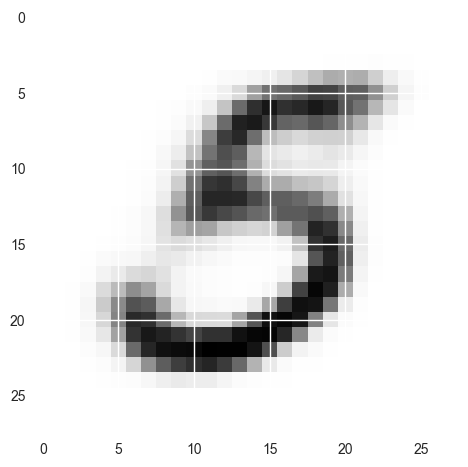

In [9]:
b_size = 1
rand_norm_v = torch.randn(b_size, 4).to(device)
vae_rand_imgs = convae.decoder(rand_norm_v)
plt.imshow(vae_rand_imgs[0].view(1, 1, 28, 28)[0][0].detach().cpu())

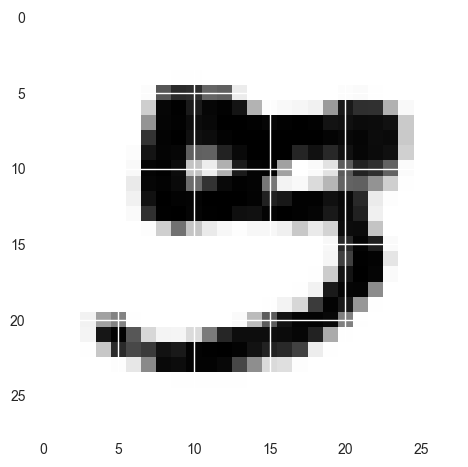

In [27]:
rand_norm_v = torch.randn(b_size, 100,1,1).to(device)
gan_rand_imgs = generator(rand_norm_v)
plt.imshow(gan_rand_imgs[0].view(1, 1, 28, 28)[0][0].detach().cpu())

This section will calculate the Distance based suprise adequacy which is an alternative to LSA (without optimization, but can be used for it)

In [28]:
def select_label(digit):
    labels = train_dataset.targets  
    selected_digit = digit
    indices = (labels == selected_digit).nonzero(as_tuple=True)[0]
    selected_label = labels[indices[0]]
    return selected_label

In [30]:
label = select_label(5)
vae_dsa = calculate_dsa(vae_rand_imgs, act_layer, 11, label, train_data_loader)

In [31]:
label = select_label(5)
gen_dsa =calculate_dsa(gan_rand_imgs, act_layer, 11, label, train_data_loader)

In [34]:
print('DSA value for vae is:', vae_dsa,'DSA value for gan is:', gen_dsa)

DSA value for vae is: 0.73790574 DSA value for gan is: 1.5715488


This Section will calculate the LSA during optimization

In [38]:
def loss(sa, obj = -10):
    return abs(sa - obj)

def calc_z_lsa(z):
    vae_img = convae.decoder(z).view(-1, 1, 28,28)
    return calc_img_lsa(vae_img,  act_layer, 11, result, kde)

In [41]:
z_dim = 4
b_size = 1
rand_norm_v = torch.randn(b_size, 4).to(device)
pix_rand_img_tensor = torch.Tensor(vae_rand_imgs).to(device).view(-1, 1, 28, 28)
prev_sa = calc_z_lsa(rand_norm_v)
target_sa = 26
prev_loss = loss(prev_sa, target_sa)
opt_img = pix_rand_img_tensor.clone()
opt_z = rand_norm_v.clone()

last_diff_prop = 0.0001
opt_epoch_num = 3

hill_climbing(opt_epoch_num, opt_z, z_dim, prev_sa, target_sa, prev_loss, loss, opt_z, last_diff_prop, calc_z_lsa)

-----epoch 0 start-----
new_sa: 55.4715
# of updates: 3
change though opt: 0.0002743750810623169
-----epoch 1 start-----
new_sa: 51.4806
# of updates: 3
change though opt: 1.4268972873687744
-----epoch 2 start-----
new_sa: 42.3257
# of updates: 2
change though opt: 1.4776747226715088


In [42]:
z_dim = 4
b_size = 1
rand_norm_v = torch.randn(b_size, 4).to(device)
pix_rand_img_tensor = torch.Tensor(vae_rand_imgs).to(device).view(-1, 1, 28, 28)
prev_sa = calc_z_lsa(rand_norm_v)
target_sa = 26
prev_loss = loss(prev_sa, target_sa)
opt_img = pix_rand_img_tensor.clone()
opt_z = rand_norm_v.clone()

last_diff_prop = 5.
opt_epoch_num = 3

simulated_annealing(opt_epoch_num, opt_z, z_dim, prev_sa, target_sa, prev_loss, loss, opt_z, last_diff_prop, calc_z_lsa)

-----epoch 0 start-----
new_sa: 35.7794
# of updates: 1
change though opt: 0.2990981340408325
-----epoch 1 start-----
new_sa: 28.8783
# of updates: 3
change though opt: 1.1016786098480225
-----epoch 2 start-----
new_sa: 27.1808
# of updates: 1
change though opt: 0.5995972752571106
